In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import os


In [2]:
# Define paths
dataset_path = './Mega Project'  # Replace with your dataset path

# Define class names and their indices
class_names = ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']
class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}


In [3]:
# Data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalization for ImageNet models
])


In [4]:
# Load datasets
train_dataset = datasets.ImageFolder(root='C:/Users/Microsoft/Desktop/Mega Project/train', transform=transform)
val_dataset = datasets.ImageFolder(root='C:/Users/Microsoft/Desktop/Mega Project/val', transform=transform)

# Check and align class indices
train_dataset.class_to_idx = class_to_idx
val_dataset.class_to_idx = class_to_idx

# Define DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [5]:
class DR_CNN(nn.Module):
    def __init__(self):
        super(DR_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 56 * 56, 512)  # Adjust dimensions
        self.fc2 = nn.Linear(512, 5)  # Output for 5 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56)  # Flatten for fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # Output logits
        return x


In [6]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate model and move to device
model = DR_CNN().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)


In [7]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=11):
    model.train()
    best_accuracy = 0.0
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct_predictions / total_samples
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")
        
        # Save the best model
        if epoch_accuracy > best_accuracy:
            best_accuracy = epoch_accuracy
            torch.save(model.state_dict(), 'best_model.pth')
    print("Training complete!")


In [8]:
def evaluate_model(model, val_loader):
    model.eval()
    correct_predictions = 0
    total_samples = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    accuracy = correct_predictions / total_samples
    print(f'Validation Accuracy: {accuracy:.4f}')
    
    # Print classification report
    print(classification_report(all_labels, all_preds, target_names=class_names))


In [9]:
# Train the model
train_model(model, train_loader, criterion, optimizer, num_epochs=11)

# Evaluate the model
evaluate_model(model, val_loader)


Epoch [1/11], Loss: 1.7294, Accuracy: 0.6505
Epoch [2/11], Loss: 0.8169, Accuracy: 0.6983
Epoch [3/11], Loss: 0.7726, Accuracy: 0.7157
Epoch [4/11], Loss: 0.7496, Accuracy: 0.7245
Epoch [5/11], Loss: 0.7452, Accuracy: 0.7253
Epoch [6/11], Loss: 0.7232, Accuracy: 0.7340
Epoch [7/11], Loss: 0.7201, Accuracy: 0.7329
Epoch [8/11], Loss: 0.6988, Accuracy: 0.7389
Epoch [9/11], Loss: 0.6956, Accuracy: 0.7417
Epoch [10/11], Loss: 0.6844, Accuracy: 0.7458
Epoch [11/11], Loss: 0.6652, Accuracy: 0.7493
Training complete!
Validation Accuracy: 0.7703
                precision    recall  f1-score   support

         No_DR       0.53      0.44      0.48       370
          Mild       0.60      0.85      0.70       999
      Moderate       0.94      0.96      0.95      1805
        Severe       0.85      0.09      0.17       295
Proliferate_DR       0.77      0.25      0.38       193

      accuracy                           0.77      3662
     macro avg       0.74      0.52      0.54      3662
  weig

In [10]:
def visualize_predictions(model, dataset):
    model.eval()
    images, labels = next(iter(DataLoader(dataset, batch_size=8)))
    images, labels = images.to(device), labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
    
    # Plot the images with predictions
    plt.figure(figsize=(12, 6))
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].cpu().permute(1, 2, 0).numpy() * 0.229 + 0.485)  # Unnormalize
        plt.title(f"Pred: {class_names[predicted[i]]}\nTrue: {class_names[labels[i]]}")
        plt.axis('off')
    plt.show()


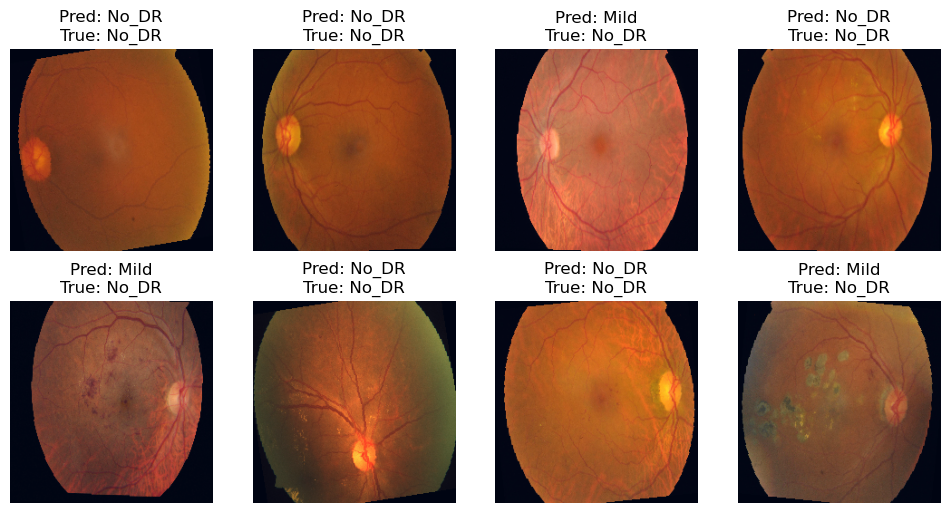

In [11]:
visualize_predictions(model, val_dataset)

In [12]:
torch.save(model.state_dict(), 'best_model.pth')